In [2]:
# import
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.display import display
plt.rc('font', family='Verdana')

import warnings
warnings.filterwarnings('ignore')

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# OTP Bank Contest
## Exploratory Analysis and Data Processing
### Описание задачи

Один из способов повышения эффективности взаимодействия банка с клиентами заключается в том, чтобы отправлять предложение о новой услуге не всем клиентам банка, а только некоторой части, выбираемой по принципу наибольшей склонности к отклику на данное предложение.

Конкурсное задание заключается в том, чтобы предложить алгоритм, который будет выдавать оценку склонности клиента к положительному отклику по его признаковому описанию. Эта оценка может (хотя и не обязана) интерпретироваться как вероятность положительного отклика. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем клиентам, у которых значение оценки выше некоторого порога.

Ссылка на конкурс:
http://poligon.machinelearning.ru/Contests/Card.aspx?synonim=otp

In [3]:
# Увеличиваем количество отображаемых столбцов датафрейма
pd.set_option('display.max_columns', 60)

# Считываем данные
data = pd.read_csv("data/Credit_OTP.csv", encoding='cp1251', sep = ';')
data.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,DL_DOCUMENT_FL,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000,6,8650,0,1,220,18.0,0,0,1,1,1,6,2,1,1580,1580,NaN
1,59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650,6,4000,0,1,137,97.0,1,0,1,1,1,6,1,1,4020,4020,NaN
2,59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126,12,4000,0,1,251,84.0,0,0,1,2,1,11,0,0,0,0,NaN
3,59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,"8491,82",6,5000,0,0,36,168.0,1,1,1,1,1,6,3,1,"1589,923333",1590,NaN
4,59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990,12,4000,0,1,83,101.0,1,0,1,2,1,16,2,1,"1152,15",2230,NaN


In [4]:
def small_categories_aggregation(column, n_samples, value='Укрупненная категория', dataset=data):
    '''
    Укрупняет категории и числовые столбцы в датасете
    :param column: имя стоблца в датасете data
    :param n_samples: порог наблюдений, ниже которого категории объединяются в одну
    :param value: значение, которым будет заполнено
    :param dataset: датасет для изменения
    :return:
    '''

    tmp_small_columns = dataset[column].value_counts()[dataset[column].value_counts() < n_samples].index

    for col in tmp_small_columns:
        dataset.at[dataset[column] == col, column] = value

In [5]:
# указано в условии
data['PREVIOUS_CARD_NUM_UTILIZED'] = data['PREVIOUS_CARD_NUM_UTILIZED'].replace(data['PREVIOUS_CARD_NUM_UTILIZED'][0], 0)

In [6]:
data.drop('AGREEMENT_RK', axis=1, inplace=True)

In [7]:
pd.read_excel('data/Credit_OTP_columns_description.xls')

,ПОЛЕ,ОПИСАНИЕ
0,AGREEMENT_RK,уникальный идентификатор объекта в выборке
1,TARGET,целевая переменная:отклик на маркетинговую кам...
2,AGE,возраст клиента
3,SOCSTATUS_WORK_FL,социальный статус клиента относительно работы ...
4,SOCSTATUS_PENS_FL,социальный статус клиента относительно пенсии ...
5,GENDER,"пол клиента (1 - мужчина, 0 - женщина)"
6,CHILD_TOTAL,количество детей клиента
7,DEPENDANTS,количество иждивенцев клиента
8,EDUCATION,образование
9,MARITAL_STATUS,семейное положение


In [8]:
data.describe()

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,TERM,DL_DOCUMENT_FL,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,PREVIOUS_CARD_NUM_UTILIZED
count,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.0,15223.000000,1.522300e+04,1.385500e+04,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000
mean,0.119030,40.406096,0.909610,0.134468,0.654536,1.099389,0.645208,0.838534,0.951192,0.886356,0.838074,0.905341,0.309794,0.116337,0.073967,0.215661,0.009788,0.019247,0.043684,8.101031,0.0,0.588649,3.039340e+03,2.922120e+02,0.611640,0.054786,0.910136,1.387769,0.751889,7.875977,0.195362,0.130198,0.019050
std,0.323835,11.601068,0.286748,0.341165,0.475535,0.995411,0.812252,0.367973,0.215473,0.317389,0.368395,0.292754,0.462424,0.320844,0.261726,0.411293,0.098451,0.137397,0.204398,4.094090,0.0,0.492095,2.624554e+05,2.436483e+04,0.487393,0.227569,0.285996,0.793566,0.988499,7.955747,0.685022,0.355702,0.137663
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.0,0.000000,-2.600000e+01,1.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.0,0.000000,4.100000e+01,2.400000e+01,0.000000,0.000000,1.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000
50%,0.000000,39.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.0,1.000000,1.080000e+02,4.800000e+01,1.000000,0.000000,1.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000
75%,0.000000,50.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.0,1.000000,2.040000e+02,1.100000e+02,1.000000,0.000000,1.000000,2.000000,1.000000,8.000000,0.000000,0.000000,0.000000
max,1.000000,67.000000,1.000000,1.000000,1.000000,10.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,0.0,1.000000,2.810200e+07,2.867959e+06,1.000000,1.000000,1.000000,11.000000,11.000000,114.000000,13.000000,8.000000,2.000000


## Missing

In [9]:
for i in data.columns:
    print(i)
    print(data[i].unique())
    print()

TARGET
[0 1]

AGE
[49 32 52 39 30 29 35 41 53 43 54 26 62 45 38 65 34 28 37 42 33 27 31 40 63
 61 44 59 48 24 23 47 58 51 56 22 36 57 50 46 55 66 25 60 64 21 67]

SOCSTATUS_WORK_FL
[1 0]

SOCSTATUS_PENS_FL
[0 1]

GENDER
[1 0]

CHILD_TOTAL
[ 2  3  4  1  0  5  6  7  8 10]

DEPENDANTS
[1 3 0 2 4 5 6 7]

EDUCATION
['Среднее специальное' 'Среднее' 'Неполное среднее' 'Высшее'
 'Неоконченное высшее' 'Два и более высших образования' 'Ученая степень']

MARITAL_STATUS
['Состою в браке' 'Гражданский брак' 'Разведен(а)' 'Не состоял в браке'
 'Вдовец/Вдова']

GEN_INDUSTRY
['Торговля' 'Информационные технологии' 'Образование'
 'Государственная служба' 'Другие сферы' 'Сельское хозяйство'
 'Здравоохранение' 'Металлургия/Промышленность/Машиностроение' nan
 'Коммунальное хоз-во/Дорожные службы' 'Строительство' 'Транспорт'
 'Банк/Финансы' 'Ресторанный бизнес/Общественное питание' 'Страхование'
 'Нефтегазовая промышленность' 'СМИ/Реклама/PR-агенства' 'Энергетика'
 'Салоны красоты и здоровья' 'ЧОП/Детектив

In [10]:
# одно уникальное значение
data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)

In [11]:
miss_columns = data.count(axis=0)[data.count(axis=0) < len(data)].index

for i in miss_columns:
    print(data.isnull()[i].value_counts())
    print()
    
miss_columns

False    13856
True      1367
Name: GEN_INDUSTRY, dtype: int64

False    13856
True      1367
Name: GEN_TITLE, dtype: int64

False    13856
True      1367
Name: ORG_TP_STATE, dtype: int64

False    13858
True      1365
Name: ORG_TP_FCAPITAL, dtype: int64

False    13856
True      1367
Name: JOB_DIR, dtype: int64

False    14928
True       295
Name: TP_PROVINCE, dtype: int64

False    15222
True         1
Name: REGION_NM, dtype: int64

False    13855
True      1368
Name: WORK_TIME, dtype: int64



Index(['GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL',
       'JOB_DIR', 'TP_PROVINCE', 'REGION_NM', 'WORK_TIME'],
      dtype='object')

In [12]:
for i in miss_columns:
    print(i)
    print(data[i].value_counts())
    print()

GEN_INDUSTRY
Торговля                                     2385
Другие сферы                                 1709
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108
Салоны красоты и здоровья            

In [13]:
data['GEN_INDUSTRY'].fillna('Пропуски', inplace=True)

In [14]:
data['GEN_INDUSTRY'].value_counts()

Торговля                                     2385
Другие сферы                                 1709
Пропуски                                     1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [15]:
small_categories_aggregation('GEN_INDUSTRY', 100)

In [16]:
data['GEN_TITLE'].value_counts()

Специалист                        7010
Рабочий                           3075
Служащий                           904
Руководитель среднего звена        697
Работник сферы услуг               563
Высококвалифиц. специалист         549
Руководитель высшего звена         427
Индивидуальный предприниматель     217
Другое                             177
Руководитель низшего звена         136
Военнослужащий по контракту         88
Партнер                             13
Name: GEN_TITLE, dtype: int64

In [17]:
data['GEN_TITLE'].fillna('Пропуски', inplace=True)

In [18]:
small_categories_aggregation('GEN_TITLE', 200)

In [19]:
data['GEN_TITLE'].value_counts()

Специалист                        7010
Рабочий                           3075
Пропуски                          1367
Служащий                           904
Руководитель среднего звена        697
Работник сферы услуг               563
Высококвалифиц. специалист         549
Руководитель высшего звена         427
Укрупненная категория              414
Индивидуальный предприниматель     217
Name: GEN_TITLE, dtype: int64

In [20]:
data['ORG_TP_STATE'].value_counts()

Частная компания                  6523
Государственная комп./учреж.      6112
Индивидуальный предприниматель     957
Некоммерческая организация         243
Частная ком. с инос. капиталом      21
Name: ORG_TP_STATE, dtype: int64

In [21]:
data['ORG_TP_STATE'].fillna('Пропуски', inplace=True)

In [22]:
small_categories_aggregation('ORG_TP_STATE', 250)

In [23]:
data['ORG_TP_STATE'].value_counts()

Частная компания                  6523
Государственная комп./учреж.      6112
Пропуски                          1367
Индивидуальный предприниматель     957
Укрупненная категория              264
Name: ORG_TP_STATE, dtype: int64

In [24]:
data['ORG_TP_FCAPITAL'].value_counts()

Без участия    13688
С участием       170
Name: ORG_TP_FCAPITAL, dtype: int64

In [25]:
data['ORG_TP_FCAPITAL'].fillna('С участием', inplace=True)

In [26]:
data['ORG_TP_FCAPITAL'].value_counts()

Без участия    13688
С участием      1535
Name: ORG_TP_FCAPITAL, dtype: int64

In [27]:
data['JOB_DIR'].value_counts()

Участие в основ. деятельности    11452
Вспомогательный техперсонал       1025
Бухгалтерия, финансы, планир.      481
Адм-хоз. и трансп. службы          279
Снабжение и сбыт                   217
Служба безопасности                164
Кадровая служба и секретариат      101
Пр-техн. обесп. и телеком.          75
Юридическая служба                  53
Реклама и маркетинг                  9
Name: JOB_DIR, dtype: int64

In [28]:
data['JOB_DIR'].fillna('Пропуски', inplace=True)

In [29]:
small_categories_aggregation('JOB_DIR', 102)

In [30]:
data['JOB_DIR'].value_counts()

Участие в основ. деятельности    11452
Пропуски                          1367
Вспомогательный техперсонал       1025
Бухгалтерия, финансы, планир.      481
Адм-хоз. и трансп. службы          279
Укрупненная категория              238
Снабжение и сбыт                   217
Служба безопасности                164
Name: JOB_DIR, dtype: int64

In [31]:
data['TP_PROVINCE'].value_counts()

Краснодарский край         790
Кемеровская область        668
Алтайский край             436
Приморский край            413
Читинская область          412
Ставропольский край        411
Ростовская область         405
Челябинская область        354
Свердловская область       340
Волгоградская область      339
Кировская область          333
Саратовская область        317
Воронежская область        312
Красноярский край          295
Вологодская область        292
Омская область             286
Татарстан                  272
Хабаровский край           258
Санкт-Петербург            254
Оренбургская область       251
Тульская область           245
Архангельская область      243
Новосибирская область      238
Самарская область          236
Амурская область           224
Курская область            212
Белгородская область       211
Бурятия                    211
Ярославская область        208
Иркутская область          204
                          ... 
Пермская область           162
Чувашия 

In [32]:
data['TP_PROVINCE'].unique()

array(['Оренбургская область', 'Ставропольский край', 'Иркутская область',
       'Ростовская область', 'Белгородская область', 'Вологодская область',
       'Волгоградская область', 'Ярославская область',
       'Краснодарский край', 'Карелия', 'Хабаровский край',
       'Калужская область', 'Еврейская АО', 'Красноярский край',
       'Свердловская область', 'Камчатская область', 'Алтайский край',
       'Липецкая область', 'Адыгея', 'Челябинская область',
       'Мурманская область', 'Амурская область', 'Санкт-Петербург',
       'Тверская область', 'Тульская область', 'Воронежская область',
       'Кемеровская область', 'Пермская область', 'Омская область',
       'Саратовская область', 'Башкирия', 'Мордовская республика',
       'Новосибирская область', 'Магаданская область',
       'Ханты-Мансийский АО', 'Псковская область', 'Самарская область',
       'Орловская область', 'Ивановская область', 'Читинская область',
       'Татарстан', 'Якутия', 'Кировская область', 'Астраханская об

In [33]:
data['TP_PROVINCE'].fillna('Пропуски', inplace=True)

In [34]:
small_categories_aggregation('TP_PROVINCE', 90)

In [35]:
data['TP_PROVINCE'].value_counts()[:20]

Краснодарский край       790
Кемеровская область      668
Алтайский край           436
Приморский край          413
Читинская область        412
Ставропольский край      411
Ростовская область       405
Челябинская область      354
Свердловская область     340
Волгоградская область    339
Укрупненная категория    338
Кировская область        333
Саратовская область      317
Воронежская область      312
Пропуски                 295
Красноярский край        295
Вологодская область      292
Омская область           286
Татарстан                272
Хабаровский край         258
Name: TP_PROVINCE, dtype: int64

In [36]:
data['REGION_NM'].value_counts()

ЮЖНЫЙ                 2179
ЦЕНТРАЛЬНЫЙ 2         1934
ЗАПАДНО-СИБИРСКИЙ     1835
ЦЕНТРАЛЬНЫЙ 1         1653
ПОВОЛЖСКИЙ            1436
ПРИВОЛЖСКИЙ           1270
ВОСТОЧНО-СИБИРСКИЙ    1256
УРАЛЬСКИЙ             1195
ДАЛЬНЕВОСТОЧНЫЙ       1141
СЕВЕРО-ЗАПАДНЫЙ       1028
ЦЕНТРАЛЬНЫЙ ОФИС       295
Name: REGION_NM, dtype: int64

In [37]:
data['REGION_NM'].fillna(data['REGION_NM'].value_counts().index[0], inplace=True)

In [38]:
data['WORK_TIME'].value_counts()

36.0      1263
24.0      1140
60.0       989
12.0       861
48.0       800
120.0      544
72.0       518
6.0        448
18.0       423
84.0       419
96.0       378
180.0      319
108.0      274
240.0      218
144.0      211
8.0        188
30.0       187
132.0      165
156.0      155
204.0      153
7.0        144
168.0      139
192.0      135
3.0        134
4.0        119
360.0      114
300.0      108
10.0       107
216.0      107
14.0        98
          ... 
860.0        1
600.0        1
463.0        1
129.0        1
136.0        1
99.0         1
239.0        1
179.0        1
303.0        1
407.0        1
187.0        1
445.0        1
166.0        1
107.0        1
242.0        1
236.0        1
244.0        1
457.0        1
195.0        1
185.0        1
1254.0       1
395.0        1
4320.0       1
169.0        1
229.0        1
576.0        1
176.0        1
207.0        1
362.0        1
391.0        1
Name: WORK_TIME, Length: 302, dtype: int64

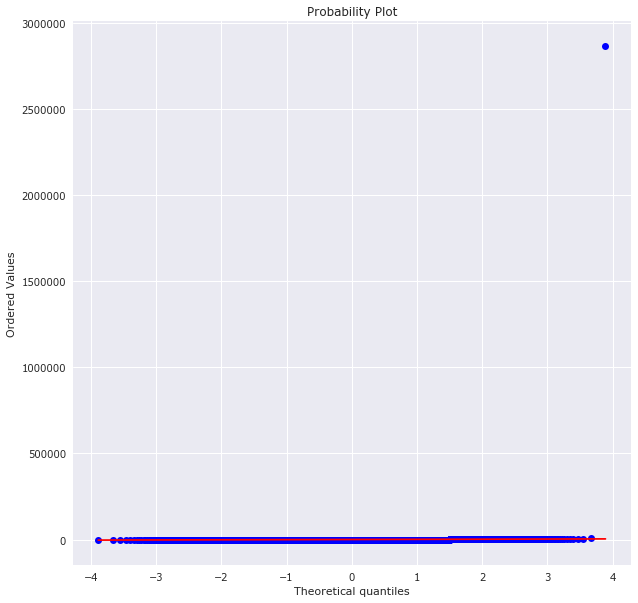

In [39]:
## QQ Plot
plt.subplots(figsize=(10, 10))

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(data['WORK_TIME'].dropna().sort_values(), dist="norm", plot=plt)
plt.show()

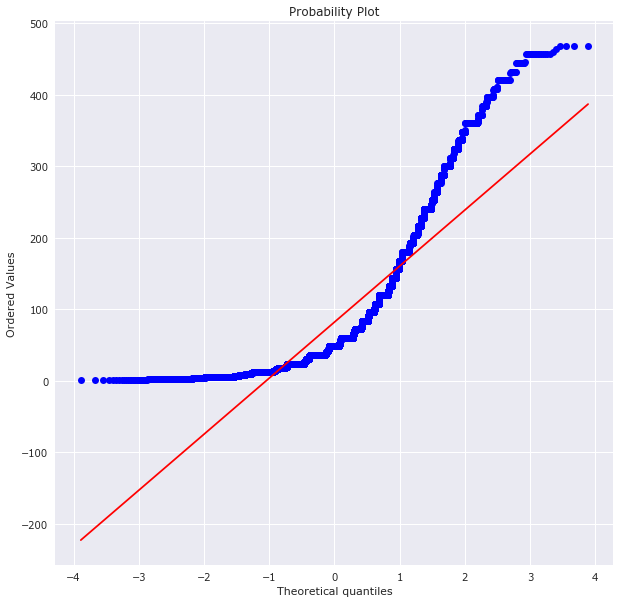

In [40]:
plt.subplots(figsize=(10, 10))

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(data['WORK_TIME'].dropna().sort_values()[:13800], dist="norm", plot=plt)
plt.show()

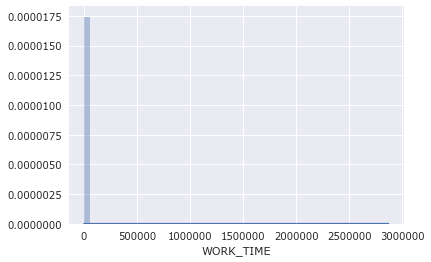

In [41]:
sns.distplot(data['WORK_TIME'].dropna().sort_values().dropna())

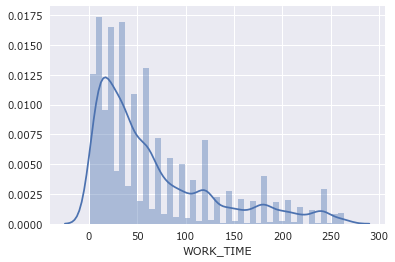

In [42]:
sns.distplot(data['WORK_TIME'].dropna().sort_values()[:13000].dropna())

In [43]:
data['WORK_TIME'].dropna().sort_values()[:13800]

10089      1.0
2585       1.0
5415       1.0
8258       1.0
9195       1.0
675        1.0
1872       1.0
11066      1.0
13279      1.0
13345      1.0
13371      1.0
10509      1.0
12648      1.0
1905       1.0
11951      1.0
3938       1.0
6019       1.0
8142       1.0
9864       1.0
3874       1.0
9288       1.0
11727      1.0
279        1.0
11600      1.0
1573       1.0
9279       1.0
201        1.0
11506      1.0
8021       2.0
8450       2.0
         ...  
6672     444.0
8081     444.0
6381     444.0
3894     444.0
9102     444.0
14330    444.0
8198     445.0
10679    456.0
6724     456.0
11476    456.0
6985     456.0
4599     456.0
815      456.0
14149    456.0
4670     456.0
14252    456.0
9670     456.0
10616    456.0
2991     456.0
4330     456.0
10286    456.0
14667    456.0
10201    456.0
8900     457.0
12340    460.0
11225    463.0
1946     468.0
1441     468.0
5096     468.0
9540     468.0
Name: WORK_TIME, Length: 13800, dtype: float64

In [44]:
data['WORK_TIME'].dropna().sort_values()[:13800].mean(), data['WORK_TIME'].dropna().sort_values()[:13800].median()

(82.04579710144928, 48.0)

In [45]:
heuristic_max = max(data['WORK_TIME'].dropna().sort_values()[:13800])
heuristic_max

468.0

# Артем! У нас есть выбросы, странные значения и пропуски. Как сделать так, чтобы мы могли за счет присваивания новых значений свести распределение к нормальному?

In [46]:
data.at[data['WORK_TIME'] >= 468, 'WORK_TIME'] = np.NaN
len(data['WORK_TIME'].dropna())

13796

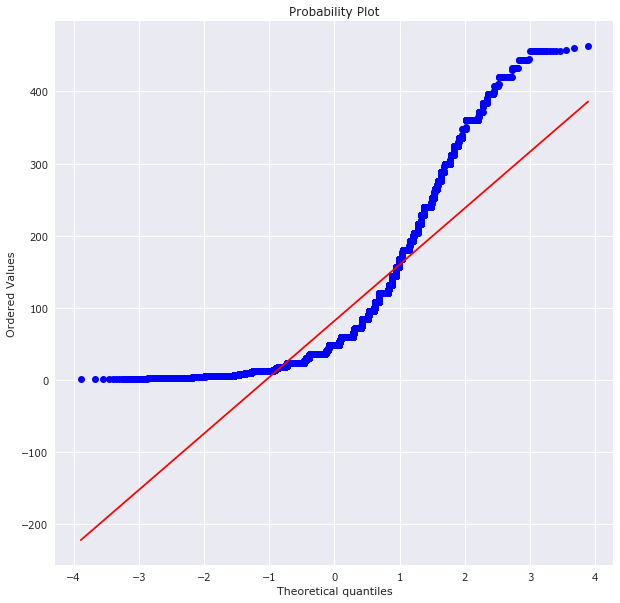

In [47]:
plt.subplots(figsize=(10, 10))

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(data['WORK_TIME'].dropna(), dist="norm", plot=plt)
plt.show()

In [48]:
data['WORK_TIME'].fillna(data['WORK_TIME'].dropna().mean(), inplace=True)

In [49]:
miss_columns = data.count(axis=0)[data.count(axis=0) < len(data)].index

for i in miss_columns:
    print(data.isnull()[i].value_counts())
    print()
    
miss_columns

Index([], dtype='object')

In [50]:
for i in ['TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER', 
          'EDUCATION', 'MARITAL_STATUS', 'GEN_INDUSTRY', 'GEN_TITLE',
          'ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR', 'REG_ADDRESS_PROVINCE',
          'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE', 'REGION_NM',
          'REG_FACT_FL', 'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL', 
          'REG_FACT_POST_TP_FL', 'FL_PRESENCE_FL', 'AUTO_RUS_FL', 'HS_PRESENCE_FL',
          'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL', 'DL_DOCUMENT_FL',
          'GPF_DOCUMENT_FL', 'FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL']:
    if i in data.columns:
        data[i]=data[i].astype('str')

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 50 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null object
REG_ADDRESS_PROVINCE          15223 non-null object
FACT_ADDRE

In [52]:
data['AGE_CATEGORY'] = 0

data.at[data['AGE'] <= 30, 'AGE_CATEGORY'] = '1'
data.at[(data['AGE'] >= 31) & (data['AGE'] <= 40), 'AGE_CATEGORY'] = '2'
data.at[(data['AGE'] >= 41) & (data['AGE'] <= 50), 'AGE_CATEGORY'] = '3'
data.at[(data['AGE'] >= 51) & (data['AGE'] <= 60), 'AGE_CATEGORY'] = '4'
data.at[(data['AGE'] >= 61) & (data['AGE'] <= 70), 'AGE_CATEGORY'] = '5'

data['AGE_CATEGORY'].value_counts()

2    4300
1    3818
3    3483
4    2936
5     686
Name: AGE_CATEGORY, dtype: int64

In [53]:
data.head()

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,AGE_CATEGORY
0,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000,6,8650,1,220,18.0,0,0,1,1,1,6,2,1,1580,1580,0.0,3
1,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650,6,4000,1,137,97.0,1,0,1,1,1,6,1,1,4020,4020,0.0,2
2,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Укрупненная категория,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126,12,4000,1,251,84.0,0,0,1,2,1,11,0,0,0,0,0.0,4
3,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,"8491,82",6,5000,0,36,168.0,1,1,1,1,1,6,3,1,"1589,923333",1590,0.0,2
4,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990,12,4000,1,83,101.0,1,0,1,2,1,16,2,1,"1152,15",2230,0.0,1


In [54]:
for i in data.columns:
    print(i)
    print(data[i].value_counts())
    print()

TARGET
0    13411
1     1812
Name: TARGET, dtype: int64

AGE
27    485
26    480
33    461
31    461
30    460
34    455
35    442
24    437
32    435
25    430
38    429
29    427
37    420
39    415
28    414
40    406
23    380
36    376
42    373
41    363
44    363
48    358
45    358
50    352
52    349
51    349
49    348
53    339
43    335
56    334
47    320
46    313
54    295
22    292
55    289
57    283
58    276
59    216
61    212
60    206
62    148
63    138
64    127
65     43
66     17
21     13
67      1
Name: AGE, dtype: int64

SOCSTATUS_WORK_FL
1    13847
0     1376
Name: SOCSTATUS_WORK_FL, dtype: int64

SOCSTATUS_PENS_FL
0    13176
1     2047
Name: SOCSTATUS_PENS_FL, dtype: int64

GENDER
1    9964
0    5259
Name: GENDER, dtype: int64

CHILD_TOTAL
1     5087
0     4984
2     4140
3      799
4      133
5       59
6       12
7        5
10       3
8        1
Name: CHILD_TOTAL, dtype: int64

DEPENDANTS
0    8226
1    4535
2    2167
3     243
4      42
5       5
6    

POSTAL_ADDRESS_PROVINCE
Краснодарский край             674
Кемеровская область            674
Алтайский край                 456
Читинская область              426
Приморский край                415
Ростовская область             404
Свердловская область           348
Волгоградская область          331
Саратовская область            326
Воронежская область            302
Вологодская область            293
Челябинская область            292
Татарстан                      287
Омская область                 286
Кировская область              266
Архангельская область          255
Хабаровский край               254
Оренбургская область           251
Тульская область               249
Самарская область              239
Красноярский край              239
Башкирия                       221
Новосибирская область          215
Курская область                214
Белгородская область           212
Липецкая область               204
Московская область             203
Иркутская область              

In [55]:
data.at[(data['AGE'] >= 64), 'AGE'] = 64
data.at[(data['AGE'] <= 22), 'AGE'] = 22

In [56]:
data['CHILD_TOTAL']=data['CHILD_TOTAL'].astype('str')
small_categories_aggregation('CHILD_TOTAL', 100)

In [57]:
data['CHILD_TOTAL'].value_counts()

1                        5087
0                        4984
2                        4140
3                         799
4                         133
Укрупненная категория      80
Name: CHILD_TOTAL, dtype: int64

In [58]:
data['DEPENDANTS'] = data['DEPENDANTS'].astype('str')
small_categories_aggregation('DEPENDANTS', 3000)

In [59]:
data['DEPENDANTS'].value_counts()

0                        8226
1                        4535
Укрупненная категория    2462
Name: DEPENDANTS, dtype: int64

In [60]:
data.at[(data['EDUCATION'] == 'Ученая степень'), 'EDUCATION'] = 'Высшее'
data.at[(data['EDUCATION'] == 'Два и более высших образования'), 'EDUCATION'] = 'Высшее'
data['EDUCATION'].value_counts()

Среднее специальное    6518
Среднее                4679
Высшее                 3154
Неоконченное высшее     532
Неполное среднее        340
Name: EDUCATION, dtype: int64

In [61]:
data.at[(data['FAMILY_INCOME'] == 'до 5000 руб.'), 'FAMILY_INCOME'] = 'от 5000 до 10000 руб.'
data['FAMILY_INCOME'].value_counts()

от 10000 до 20000 руб.    7077
от 20000 до 50000 руб.    6082
от 5000 до 10000 руб.     1572
свыше 50000 руб.           492
Name: FAMILY_INCOME, dtype: int64

In [62]:
for i in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
    if i in data.columns:
        data[i] = data[i].str.replace(',', '.').astype('float')

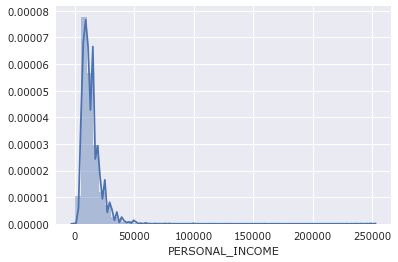

In [63]:
sns.distplot(data['PERSONAL_INCOME'])

In [64]:
small_categories_aggregation('REG_ADDRESS_PROVINCE', 55)

In [65]:
data['REG_ADDRESS_PROVINCE'].value_counts()

Краснодарский край         674
Кемеровская область        674
Алтайский край             459
Читинская область          426
Приморский край            416
Ростовская область         407
Свердловская область       349
Волгоградская область      331
Саратовская область        331
Воронежская область        301
Челябинская область        292
Вологодская область        292
Татарстан                  287
Омская область             287
Кировская область          264
Архангельская область      257
Оренбургская область       253
Тульская область           252
Хабаровский край           252
Красноярский край          239
Самарская область          235
Башкирия                   222
Курская область            217
Белгородская область       215
Новосибирская область      214
Липецкая область           206
Иркутская область          202
Тюменская область          199
Бурятия                    196
Ярославская область        194
                          ... 
Смоленская область         159
Мурманск

In [66]:
data.at[(data['OWN_AUTO'] == 2), 'OWN_AUTO'] = 1
data['OWN_AUTO'].value_counts()

0    13453
1     1770
Name: OWN_AUTO, dtype: int64

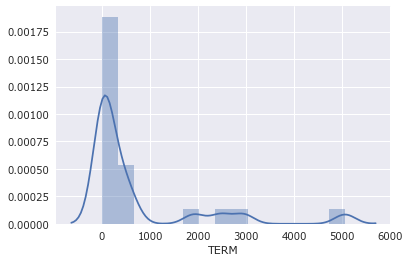

In [67]:
sns.distplot(data['TERM'].value_counts())

In [68]:
data['TERM'].value_counts()

6     5063
12    2951
10    2473
3     1919
5      626
9      542
4      446
8      401
18     263
24     166
7      143
11      63
36      50
15      49
14      20
13      17
16      15
20       6
23       4
22       3
30       2
19       1
Name: TERM, dtype: int64

In [69]:
data.at[(data['TERM'] == 22), 'TERM'] = 20
data.at[(data['TERM'] == 23), 'TERM'] = 20
data.at[(data['TERM'] == 19), 'TERM'] = 20
data.at[(data['TERM'] == 30), 'TERM'] = 36
data.at[(data['TERM'] == 13), 'TERM'] = 14
data.at[(data['TERM'] == 16), 'TERM'] = 20

data['TERM'].value_counts()

6     5063
12    2951
10    2473
3     1919
5      626
9      542
4      446
8      401
18     263
24     166
7      143
11      63
36      52
15      49
14      37
20      29
Name: TERM, dtype: int64

In [70]:
data.at[(data['FACT_LIVING_TERM'] < 0), 'FACT_LIVING_TERM'] = abs(data[data['FACT_LIVING_TERM'] < 0]['FACT_LIVING_TERM'])

In [71]:
data.at[(data['LOAN_NUM_CLOSED'] >= 6), 'LOAN_NUM_CLOSED'] = 5
data.at[(data['LOAN_NUM_CLOSED'] == 8), 'LOAN_NUM_CLOSED'] = 5
data.at[(data['LOAN_NUM_CLOSED'] == 11), 'LOAN_NUM_CLOSED'] = 5
data.at[(data['LOAN_NUM_CLOSED'] == 6), 'LOAN_NUM_CLOSED'] = 5


data['LOAN_NUM_CLOSED'].value_counts()

0    7791
1    4761
2    1770
3     603
4     202
5      96
Name: LOAN_NUM_CLOSED, dtype: int64

In [72]:
data['LOAN_NUM_PAYM'].value_counts()[25:50]

28    55
27    54
26    53
30    35
29    35
32    33
33    31
31    28
34    28
37    28
36    26
41    21
40    19
35    16
39    14
46    14
42    14
45    11
38    10
44     9
43     9
47     9
48     8
51     7
52     7
Name: LOAN_NUM_PAYM, dtype: int64

In [73]:
# ?
data.at[(data['LOAN_NUM_PAYM'] >= 40), 'LOAN_NUM_PAYM'] = 40
data.at[(data['LOAN_NUM_PAYM'] == 35), 'LOAN_NUM_PAYM'] = 36
data.at[(data['LOAN_NUM_PAYM'] == 39), 'LOAN_NUM_PAYM'] = 36
data.at[(data['LOAN_NUM_PAYM'] == 38), 'LOAN_NUM_PAYM'] = 36

data['LOAN_NUM_PAYM'].value_counts()

4     3978
5     2298
6     2029
3     1647
1      435
2      399
7      368
10     341
12     334
9      310
8      300
11     259
15     237
16     236
18     209
13     208
14     206
40     178
17     148
20     147
21     105
19     102
22      88
24      87
25      67
36      66
23      61
28      55
27      54
26      53
29      35
30      35
32      33
33      31
34      28
37      28
31      28
Name: LOAN_NUM_PAYM, dtype: int64

In [74]:
# ?
data.at[(data['LOAN_DLQ_NUM'] >= 5), 'LOAN_DLQ_NUM'] = 5

data['LOAN_DLQ_NUM'].value_counts()

0    13301
1     1416
2      280
3       96
5       82
4       48
Name: LOAN_DLQ_NUM, dtype: int64

In [75]:
data['WITHOUT_DELAY'] = 1
data.at[(data['LOAN_MAX_DLQ_AMT'] == 0), 'WITHOUT_DELAY'] = 0
data['WITHOUT_DELAY'] = data['WITHOUT_DELAY'].astype('str')

In [76]:
data.at[(data['PREVIOUS_CARD_NUM_UTILIZED'] == 2.0), 'PREVIOUS_CARD_NUM_UTILIZED'] = 1.0

data['PREVIOUS_CARD_NUM_UTILIZED'].value_counts()

0.0    14935
1.0      288
Name: PREVIOUS_CARD_NUM_UTILIZED, dtype: int64

In [77]:
data['REG_ADDRESS_PROVINCE'] = data['REG_ADDRESS_PROVINCE'].map(data['REG_ADDRESS_PROVINCE'].value_counts())
data['FACT_ADDRESS_PROVINCE'] = data['FACT_ADDRESS_PROVINCE'].map(data['FACT_ADDRESS_PROVINCE'].value_counts())

In [78]:
data_dummies = pd.get_dummies(data)

In [80]:
data_dummies.to_csv('data/Credit_OTP_processed.csv', encoding='utf-8')